In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10,ImageFolder
from torchvision.utils import make_grid,save_image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [82]:
from tqdm.notebook import tqdm
import os
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
                                ])

In [84]:
dataset = CIFAR10('./data',train=True,transform=transform,download=True)

Files already downloaded and verified


In [85]:
def denorm(img):
  return img * 0.5 + 0.5

torch.Size([3, 32, 32])


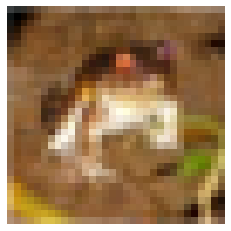

In [86]:
img,_ = dataset[0]
plt.imshow(denorm(img).permute(1,2,0))
print(img.shape)
plt.axis('off')
plt.show()

## Dataloader and Visualising a batch of image

In [87]:
batch_size = 128
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

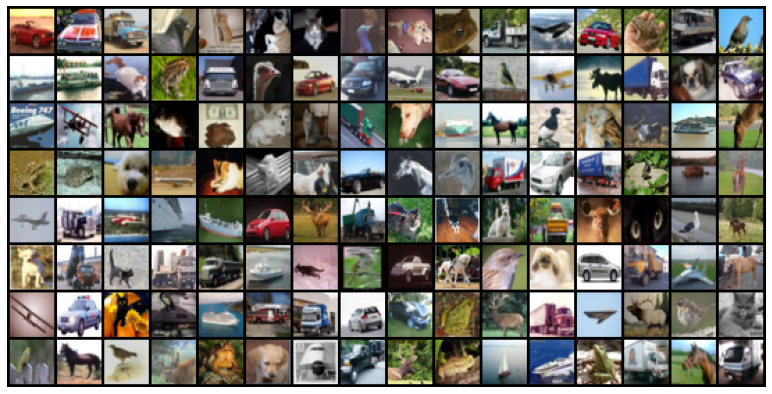

In [88]:
for img,_ in train_loader:
  plt.figure(figsize=(18,7))
  plt.axis('off')
  plt.imshow(make_grid(denorm(img),nrow=16).permute(1,2,0))
  break

## Using GPU device

In [89]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device    

device(type='cuda')

## Discriminator model

In [90]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False), #Strided Conv
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    # out = 64 x 16 x 16

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out = 128 x 8 x 8
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    # out = 256 x 4 x 4
    
    nn.Conv2d(256,1,kernel_size=4,stride=1,padding=0,bias=False),
    # out = 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()

)

## Generator model

In [91]:
latent_size = 128

In [92]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,256,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    # out = 256 x 4 x 4
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    # out = 128 x 8 x 8

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # out =  64 x 16 x 16

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
     # out = 3 x 32 x 32
    nn.Tanh()
    
)

In [93]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [94]:
opt_d = torch.optim.Adam(discriminator.parameters(),lr=0.0002)
opt_g = torch.optim.Adam(generator.parameters(),lr=0.0002)

## Training the discriminator

In [95]:
def train_discriminator(real_images):

  opt_d.zero_grad()

  real_labels = torch.ones(real_images.size(0),1).to(device)
  real_preds = discriminator(real_images)
  real_loss = F.binary_cross_entropy(real_preds,real_labels)
  real_score = torch.mean(real_preds).item()
  
  xb = torch.randn(batch_size,latent_size,1,1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)
  fake_images = generator(xb)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds,fake_labels)
  fake_score = torch.mean(fake_preds).item()

  d_loss = real_loss + fake_loss
  d_loss.backward()
  opt_d.step()
  return d_loss.item(),real_score,fake_score

## Training the Generator

In [96]:
def train_generator():

  opt_g.zero_grad()

  xb = torch.randn(batch_size,latent_size,1,1).to(device)
  fake_img = generator(xb)
  labels = torch.ones(batch_size,1).to(device)
  g_loss = F.binary_cross_entropy(discriminator(fake_img),labels)

  g_loss.backward()
  opt_g.step()
  return g_loss.item()

## Generating a new batch of images and saving them

In [97]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [98]:
fixed_latent = torch.randn(batch_size,latent_size,1,1).to(device)
def save_fake_image(index, latent_tensors):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    print('Saving', fake_fname)

## Training The Model

In [99]:
start_idx = 1
def fit(num_epochs):
  real_scores = []
  fake_scores = []
  d_losses = []
  g_losses = []

  for epoch in range(num_epochs):

    for img,_ in tqdm(train_loader):
      img = img.to(device)
      d_loss,real_score,fake_score = train_discriminator(img)
      g_loss = train_generator()

    real_scores.append(real_score)
    fake_scores.append(fake_score)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, num_epochs, g_loss, d_loss, real_score, fake_score))
    
    # Save generated images
    save_fake_image(epoch+start_idx, fixed_latent)
  
  return d_losses,g_losses,real_scores,fake_scores

In [100]:
history = fit(50)


Epoch [1/50], loss_g: 7.0851, loss_d: 0.0145, real_score: 0.9976, fake_score: 0.0118
Saving generated-images-0001.png



Epoch [2/50], loss_g: 7.5603, loss_d: 0.0056, real_score: 0.9978, fake_score: 0.0033
Saving generated-images-0002.png



Epoch [3/50], loss_g: 5.6313, loss_d: 0.0337, real_score: 0.9886, fake_score: 0.0194
Saving generated-images-0003.png



Epoch [4/50], loss_g: 6.9454, loss_d: 0.0363, real_score: 0.9855, fake_score: 0.0188
Saving generated-images-0004.png



Epoch [5/50], loss_g: 8.0590, loss_d: 0.0792, real_score: 0.9472, fake_score: 0.0016
Saving generated-images-0005.png



Epoch [6/50], loss_g: 9.0900, loss_d: 0.0202, real_score: 0.9854, fake_score: 0.0034
Saving generated-images-0006.png



Epoch [7/50], loss_g: 7.4031, loss_d: 0.0286, real_score: 0.9783, fake_score: 0.0037
Saving generated-images-0007.png



Epoch [8/50], loss_g: 8.1100, loss_d: 0.0148, real_score: 0.9903, fake_score: 0.0036
Saving generated-images-0008.png



Epoch [9/50], loss_g: 7.4755, loss_d: 0.0267, real_score: 0.9784, fake_score: 0.0020
Saving generated-images-0009.png



Epoch [10/50], loss_g: 5.9367, loss_d: 0.0207, real_score: 0.9857, fake_score: 0.0040
Saving generated-images-0010.png



Epoch [11/50], loss_g: 7.3583, loss_d: 0.0125, real_score: 0.9940, fake_score: 0.0062
Saving generated-images-0011.png



Epoch [12/50], loss_g: 7.3366, loss_d: 0.0626, real_score: 0.9830, fake_score: 0.0266
Saving generated-images-0012.png



Epoch [13/50], loss_g: 6.8978, loss_d: 0.0894, real_score: 0.9997, fake_score: 0.0484
Saving generated-images-0013.png



Epoch [14/50], loss_g: 7.3201, loss_d: 0.0810, real_score: 0.9456, fake_score: 0.0037
Saving generated-images-0014.png



Epoch [15/50], loss_g: 8.3052, loss_d: 0.0657, real_score: 0.9555, fake_score: 0.0101
Saving generated-images-0015.png



Epoch [16/50], loss_g: 5.9241, loss_d: 0.0178, real_score: 0.9909, fake_score: 0.0078
Saving generated-images-0016.png



Epoch [17/50], loss_g: 9.0988, loss_d: 0.1088, real_score: 0.9271, fake_score: 0.0037
Saving generated-images-0017.png



Epoch [18/50], loss_g: 7.5044, loss_d: 0.1215, real_score: 0.9166, fake_score: 0.0054
Saving generated-images-0018.png



Epoch [19/50], loss_g: 5.5990, loss_d: 0.0834, real_score: 0.9678, fake_score: 0.0440
Saving generated-images-0019.png



Epoch [20/50], loss_g: 6.4198, loss_d: 0.0691, real_score: 0.9576, fake_score: 0.0136
Saving generated-images-0020.png



Epoch [21/50], loss_g: 8.6179, loss_d: 0.0607, real_score: 0.9500, fake_score: 0.0006
Saving generated-images-0021.png



Epoch [22/50], loss_g: 7.3587, loss_d: 0.0601, real_score: 0.9772, fake_score: 0.0189
Saving generated-images-0022.png



Epoch [23/50], loss_g: 5.6149, loss_d: 0.1000, real_score: 0.9661, fake_score: 0.0287
Saving generated-images-0023.png



Epoch [24/50], loss_g: 6.8058, loss_d: 0.0804, real_score: 0.9435, fake_score: 0.0074
Saving generated-images-0024.png



Epoch [25/50], loss_g: 11.5025, loss_d: 0.1513, real_score: 0.9003, fake_score: 0.0003
Saving generated-images-0025.png



Epoch [26/50], loss_g: 6.4076, loss_d: 0.0509, real_score: 0.9748, fake_score: 0.0209
Saving generated-images-0026.png



Epoch [27/50], loss_g: 6.4012, loss_d: 0.0502, real_score: 0.9958, fake_score: 0.0388
Saving generated-images-0027.png



Epoch [28/50], loss_g: 5.2277, loss_d: 0.0790, real_score: 0.9576, fake_score: 0.0224
Saving generated-images-0028.png



Epoch [29/50], loss_g: 5.2987, loss_d: 0.0991, real_score: 0.9443, fake_score: 0.0176
Saving generated-images-0029.png



Epoch [30/50], loss_g: 8.1387, loss_d: 0.0417, real_score: 0.9709, fake_score: 0.0031
Saving generated-images-0030.png



Epoch [31/50], loss_g: 5.7686, loss_d: 0.1483, real_score: 0.9592, fake_score: 0.0806
Saving generated-images-0031.png



Epoch [32/50], loss_g: 4.6701, loss_d: 0.0588, real_score: 0.9744, fake_score: 0.0277
Saving generated-images-0032.png



Epoch [33/50], loss_g: 5.5880, loss_d: 0.0732, real_score: 0.9774, fake_score: 0.0431
Saving generated-images-0033.png



Epoch [34/50], loss_g: 8.4606, loss_d: 0.0751, real_score: 0.9555, fake_score: 0.0160
Saving generated-images-0034.png



Epoch [35/50], loss_g: 4.2541, loss_d: 0.0936, real_score: 0.9761, fake_score: 0.0539
Saving generated-images-0035.png



Epoch [36/50], loss_g: 7.3348, loss_d: 0.0990, real_score: 0.9878, fake_score: 0.0542
Saving generated-images-0036.png



Epoch [37/50], loss_g: 4.5811, loss_d: 0.0600, real_score: 0.9777, fake_score: 0.0310
Saving generated-images-0037.png



Epoch [38/50], loss_g: 5.0863, loss_d: 0.1008, real_score: 0.9669, fake_score: 0.0524
Saving generated-images-0038.png



Epoch [39/50], loss_g: 6.2441, loss_d: 0.0522, real_score: 0.9952, fake_score: 0.0403
Saving generated-images-0039.png



Epoch [40/50], loss_g: 6.1365, loss_d: 0.4424, real_score: 0.9915, fake_score: 0.2697
Saving generated-images-0040.png



Epoch [41/50], loss_g: 4.8380, loss_d: 0.0807, real_score: 0.9801, fake_score: 0.0516
Saving generated-images-0041.png



Epoch [42/50], loss_g: 5.6183, loss_d: 0.0880, real_score: 0.9358, fake_score: 0.0076
Saving generated-images-0042.png



Epoch [43/50], loss_g: 7.0136, loss_d: 0.0872, real_score: 0.9867, fake_score: 0.0628
Saving generated-images-0043.png



Epoch [44/50], loss_g: 6.0496, loss_d: 0.1994, real_score: 0.9925, fake_score: 0.1399
Saving generated-images-0044.png



Epoch [45/50], loss_g: 5.2270, loss_d: 0.0904, real_score: 0.9920, fake_score: 0.0603
Saving generated-images-0045.png



Epoch [46/50], loss_g: 5.7945, loss_d: 0.0524, real_score: 0.9782, fake_score: 0.0255
Saving generated-images-0046.png



Epoch [47/50], loss_g: 5.6375, loss_d: 0.1315, real_score: 0.9854, fake_score: 0.0800
Saving generated-images-0047.png



Epoch [48/50], loss_g: 4.6026, loss_d: 0.1283, real_score: 0.9775, fake_score: 0.0881
Saving generated-images-0048.png



Epoch [49/50], loss_g: 6.5147, loss_d: 0.1146, real_score: 0.9131, fake_score: 0.0145
Saving generated-images-0049.png



Epoch [50/50], loss_g: 5.2468, loss_d: 0.3398, real_score: 0.7828, fake_score: 0.0086
Saving generated-images-0050.png


## Plotting The losses

In [101]:
d_losses, g_losses, real_scores, fake_scores = history

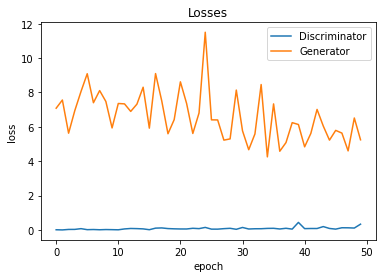

In [102]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Visualising the Generated Image

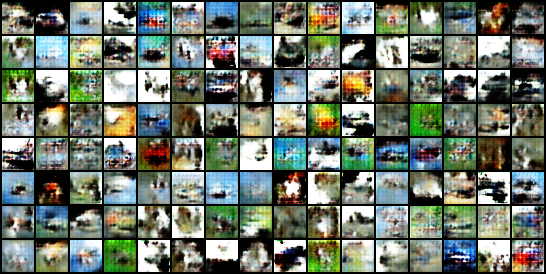

In [103]:
Image('./generated/generated-images-0025.png')

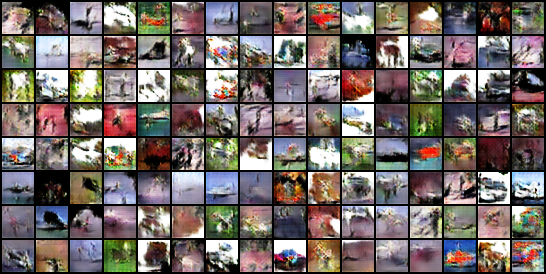

In [104]:
Image('./generated/generated-images-0050.png')

In [111]:
xb = torch.randn(2,latent_size,1,1).to(device)
img = generator(xb)
img = img.cpu().detach()

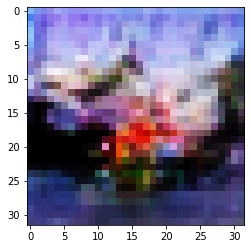

In [112]:
plt.imshow(denorm(img[1]).permute(1,2,0))